In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import random

def main():
    players_list = [40,6,23,26,15,98,1,10,55,16,
                      56,97,96,12,13,41,52,88,66,94,
                      89,86,87,77,79,72,76]
    input_data = pd.read_csv('MahjongScores.csv')

    pairings_df = create_pairings_table(players_list)
    matchups_df = create_freq_matchups(pairings_df, input_data)
    table_counts = get_table_counts(players_list)
     
    #output_tables = match_by_rating(table_counts, matchups_df)
    #print output_tables

In [2]:
def get_player_data(input_data, players_list):
    # Reduce input_data to only the rows relevant to today's players
    games_rows = pd.DataFrame()
    for i in players_list:
        games_rows = games_rows.append(input_data.loc[(input_data['PlayerId'] == i)])
    return games_rows

In [3]:
# Returns a DataFrame of all games for a single PlayerId
def get_playerid_games(input_data, PlayerId):
    grouped_by_player = input_data.groupby('PlayerId')
    listofgames = grouped_by_player.get_group(PlayerId)
    return listofgames

In [4]:
def get_split_tables(table_counts, players_list):
    tables_4p_made = 0
    tables_5p_made = 0
    split_tables = []
    start = 0
    end = 4
    
    if table_counts[1] > 0:
        for i in range(table_counts[1]):
            split_tables.append( players_list[start:end] )
            tables_4p_made += 1
            start += 4
            end += 4
    
    end += 1
    
    if table_counts[2] > 0:
        for i in range(table_counts[2]):
            split_tables.append( players_list[start:end])
            tables_5p_made += 1
            start += 5
            end += 5
        
    return split_tables

In [5]:
def get_table_counts(players_list):
    # Determine amount of 5 person tables
    if len(players_list) < 8:
        total_tables = 1
        if len(players_list) == 4:
            tables_4p = 1
            tables_5p = 0
        elif len(players_list) == 5:
            tables_4p = 0
            tables_5p = 1
        else:
            tables_4p = tables_5p = 0
    elif len(players_list) == 11:
        total_tables = 2
        tables_4p = tables_5p = 0
    else:
        tables_5p = len(players_list) % 4
        total_tables = int( len(players_list) / 4)
        tables_4p = total_tables - tables_5p
    
    table_counts = [total_tables, tables_4p, tables_5p]
    
    return table_counts

In [6]:
def create_pairings_table(players_list):
    # Create a zeros DataFrame of (#players,#players) size for matchups, with ordered indices.
    num_players = len(players_list)
    pairings_df = DataFrame(np.zeros(num_players**2).reshape(num_players,num_players))
    pairings_df.index = sorted(players_list)
    pairings_df.columns = sorted(players_list)
    return pairings_df

In [7]:
def create_freq_matchups(pairings_df, input_data):
    # Grab today's players and initialize output df
    players_list = pairings_df.columns
    matchups_df = pairings_df.copy()
        
    # Pull all rows from input_data relevant to today's players
    games_rows = get_player_data(input_data, players_list)
    
    # Make a list of unique games
    uniquegames = games_rows['GameId'].unique()
        
    # Get all players in each relevant game and populate matchup table one game at a time
    for gameid in uniquegames:
        gameid_players = []
        gameid_rows = games_rows.loc[(games_rows['GameId'] == gameid)] # Pull only the rows for players in that game
        gameid_players = gameid_rows['PlayerId'].tolist() #Give each player an index
        for i in range( len(gameid_players)): # For each player in a game
            for j in range( len(gameid_players)): 
                matchups_df.at[gameid_players[i],gameid_players[j]] += 1 # Add a game in opponent's column
    
    # Diagonal values are total # of games played for that player
    return matchups_df  

In [8]:
def create_score_matchups(pairings_df, input_data):
    players_list = pairings_df.columns
    games_rows = get_player_data(input_data, players_list)
    matchups_df = pairings_df.copy()
    
    for gameid in games_rows['GameId'].unique():
        # Pull rows for one game at a time
        gameid_players = []
        gameid_rows = games_rows.loc[(games_rows['GameId'] == gameid)]

        # Paired scores and players have the same index
        gameid_players = gameid_rows['PlayerId'].tolist()
        gameid_scores = gameid_rows['Score'].tolist()

        for i in range( len(gameid_players)): # For each player in that game
            flag = False
            for j in range( len(gameid_players)): # Get all players (including self)
                # Don't add along diagonal more than once for each player
                if (i == j):
                    if flag == False: 
                        matchups_df.at[gameid_players[i],gameid_players[j]] += gameid_scores[i]
                    flag = True
                else:
                    matchups_df.at[gameid_players[i],gameid_players[j]] += gameid_scores[i] # Add score of i to matchup sum
    
    freq_df = create_freq_matchups(pairings_df, input_data)
    for i in range( len(players_list)):
        for j in range( len(players_list)):
            matchups_df.iat[i,j] = matchups_df.iat[i,j] / np.diagonal(freq_df)[j]
    
    # Diagonal values are player's average score            
    return matchups_df

In [9]:
# Matchmaking method: Generate tables via swapping individuals (n^2.5 iterations) - swaps within same tables sometimes
def match_by_rating(table_counts, matchups_df):
    players_list = list(matchups_df.columns) # Make a list of today's players
    split_tables = get_split_tables(table_counts, players_list)
    best_tables = split_tables
    
    for i in range(int(len(players_list)**2.5)):
        
        # Calculate total table score
        improved = 0
        total_score = 0
        for table in split_tables:
            total_score += sum_ratings(table, matchups_df)

        if (i == 0):
            min_score = total_score
        
        # Save score if it's the best
        if (total_score < min_score):
            min_score = total_score
            best_tables = split_tables
            improved = 1
        
        # Use best set as basis if no improvement
        if improved == 0:
            split_tables = best_tables
        
        # Split and swap 2 players
        unsplit_tables = []
        for table in split_tables:
            unsplit_tables += table
        
        unsplit_tables = swap_two(unsplit_tables)
                
        # Split back into tables
        split_tables = get_split_tables(table_counts, unsplit_tables)
        
    return best_tables

In [10]:
# Returns aggregate data of players in players_list from input_data
def playerstats(input_data, players_list):
    fields = ['Total games played', '4p games played', '5p games played', 'Mean score', 'Stdev score',
              'Mean rank', 'Stdev rank', 'Mean 4p rank', 'Stdev 4p rank', 'Mean 5p rank', 'Stdev 5p rank']
    players_list.sort()
    results = DataFrame(index=fields, columns=players_list)
        
    # Make groupby objects of input data to take advantage of aggregate functions
    grouped_by_gameid = input_data.groupby('GameId')
    grouped_by_playerid = input_data.groupby('PlayerId')
    
    # Using .size() gives the number of players in each game
    grouped_by_gameid.size()

    # Populate the results dataframe player by player
    for player in players_list:

        # Pull games for player from groupby object
        curr_player_data = grouped_by_playerid.get_group(player)
        gamesplayed = curr_player_data.loc[:,'GameId'].tolist() # Put all games played into a list
        gameids_4p = []
        gameids_5p = []
        
        for gameid in gamesplayed:
            if (grouped_by_gameid.size()[gameid] == 4):
                gameids_4p.append(gameid)
            elif (grouped_by_gameid.size()[gameid] == 5):
                gameids_5p.append(gameid)
        games_4p = curr_player_data.loc[curr_player_data['GameId'].isin(gameids_4p)]  
        games_5p = curr_player_data.loc[curr_player_data['GameId'].isin(gameids_5p)]   
        
        # Populate results DataFrame
        results.at['Total games played', player] = len(gamesplayed)
        results.at['4p games played', player] = len(gameids_4p)
        results.at['5p games played', player] = len(gameids_5p)
        results.at['Mean score', player] = round( curr_player_data['Score'].mean(), 2)
        results.at['Stdev score', player] = round( curr_player_data['Score'].std(), 2)
        results.at['Mean rank', player] = round( curr_player_data['Rank'].mean(), 2)
        results.at['Stdev rank', player] = round( curr_player_data['Rank'].std(), 2)
        results.at['Mean 4p rank', player] = round( games_4p['Rank'].mean(), 2)
        results.at['Stdev 4p rank', player] = round( games_4p['Rank'].std(), 2)
        results.at['Mean 5p rank', player] = round( games_5p['Rank'].mean(), 2)
        results.at['Stdev 5p rank', player] = round( games_5p['Rank'].std(), 2)
    
    return results

In [11]:
def sum_ratings(table_players, matchups_df):
    table_sum = 0
    for i in table_players:
        for j in table_players:
            if i>j: # This only serves to prevent repeats
                table_sum += max(matchups_df.at[i,j],matchups_df.at[j,i])
    return table_sum

In [12]:
# Swaps 2 random entries in a list
def swap_two(entrylist):
    entrylist = entrylist[:]
    a = random.randint(0, len(entrylist) - 1)
    b = random.randint(0, len(entrylist) - 1)
    entrylist[a], entrylist[b] = entrylist[b], entrylist[a]

    return entrylist

# Next steps
Pose and answer the following questions:
    * Is there a correlation between # of 5 player tables played and standard deviation of scores?
    * What factors contribute the most to low average scores?    

In [97]:
players_list = range(1,99)
input_data = pd.read_csv('MahjongScores.csv')

pairings_df = create_pairings_table(players_list)
matchups_df = create_freq_matchups(pairings_df, input_data)
table_counts = get_table_counts(players_list)

#output_tables = match_by_rating(table_counts, matchups_df)
#print output_tables

In [98]:
playerstats(input_data, players_list)

,1,2,3,4,5,6,7,8,9,10,...,89,90,91,92,93,94,95,96,97,98
Total games played,11,2,18,87,2,68,5,1,86,11,...,12,18,3,3,11,1,1,2,1,163
4p games played,7,1,12,51,2,49,4,1,51,9,...,7,12,2,1,8,1,1,1,1,107
5p games played,4,1,6,36,0,19,1,0,35,2,...,5,6,1,2,3,0,0,1,0,56
Mean score,-4.91,-14,-4.94,3.66,-14,6.47,-2,12,3.97,-0.09,...,3.5,-4.22,-2.67,5.67,-11.18,-32,-12,5,34,6.59
Stdev score,24.6,65.05,31.68,28.4,7.07,27.07,32.72,NaN,30.63,28.31,...,28.57,26.7,29.77,43.84,21.97,NaN,NaN,36.77,NaN,26.74
Mean rank,2.82,3,2.83,2.61,3,2.41,2.6,2,2.55,2.64,...,2.67,2.83,2.67,2.33,3.09,4,3,2.5,1,2.39
Stdev rank,1.25,2.83,1.54,1.3,0,1.26,1.14,NaN,1.4,1.29,...,1.37,1.29,1.15,2.31,1.04,NaN,NaN,2.12,NaN,1.23
Mean 4p rank,2.71,1,2.5,2.27,3,2.27,2.5,2,2.27,2.67,...,2,2.33,3,1,3.25,4,3,1,1,2.13
Stdev 4p rank,1.25,NaN,1.24,1.11,0,1.15,1.29,NaN,1.2,1.22,...,1.15,1.15,1.41,NaN,0.89,NaN,NaN,NaN,NaN,1.04
Mean 5p rank,3,5,3.5,3.08,NaN,2.79,3,NaN,2.94,2.5,...,3.6,3.83,2,3,2.67,NaN,NaN,4,NaN,2.89


In [99]:
transposed = playerstats(input_data, players_list)
transposed = transposed.transpose()

In [100]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
transposed['% 5p games'] = transposed['5p games played'] / transposed['Total games played']

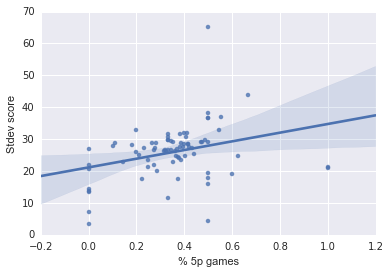

In [102]:
sns.regplot('% 5p games','Stdev score', transposed)

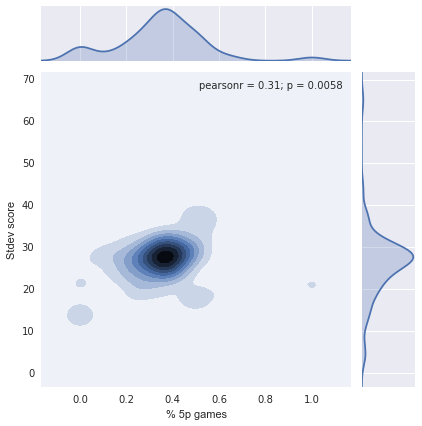

In [105]:
sns.jointplot('% 5p games','Stdev score',transposed,kind='kde')

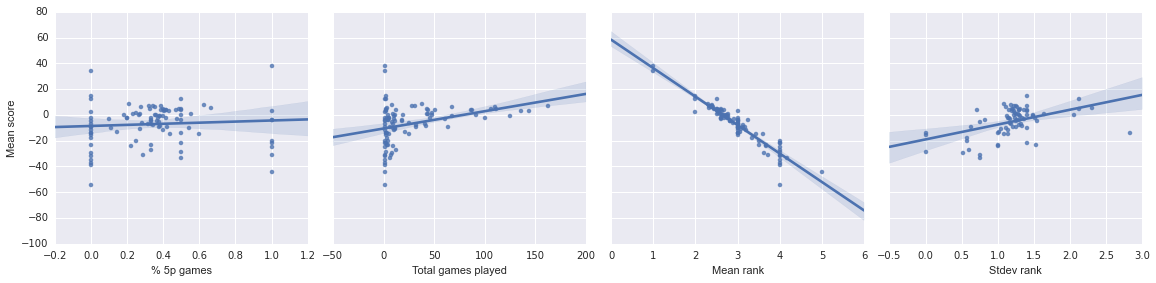

In [104]:
sns.pairplot(transposed, x_vars=['% 5p games', 'Total games played', 'Mean rank', 
                                 'Stdev rank'], y_vars=['Mean score'], kind='reg', size=4)